In [1]:
!pip install datasets transformers evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 41.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 40.0 MB/s eta 0:00:00


In [51]:
import numpy  as np
import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy

In [4]:
# read test and trian data and use Dataset library
data = DatasetDict()
df_train = pd.read_csv("/content/train_related_specific.csv", usecols = ['Record_text', 'InRelationship','General_comment_binary','General_comment','Specific_comment_binary','Specific_comment','Comment','Relevance'], on_bad_lines='skip')
df_train = df_train.rename(columns={'Specific_comment': 'label'})
data['train'] = Dataset.from_pandas(df_train)

df_test = pd.read_csv("/content/test_related_specific.csv", usecols = ['Record_text', 'InRelationship','General_comment_binary','General_comment','Specific_comment_binary','Specific_comment','Comment','Relevance'], on_bad_lines='skip')
df_test = df_test.rename(columns={'Specific_comment': 'label'})


df_test_unfreeze=df_test.copy()
df_test_unfreeze_11=df_test.copy()
df_test_freeze=df_test.copy()

data['test'] = Dataset.from_pandas(df_test)



In [8]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

In [9]:
# Tokenization function
def tokenize(batch):
    return tokenizer(batch["Record_text"], padding=True, truncation=True, max_length = 50)
# Tokenize entire dataset
tokenized_dataset = data.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/2453 [00:00<?, ? examples/s]

Map:   0%|          | 0/547 [00:00<?, ? examples/s]

In [10]:
#Select mode of model
def freeze(model,mode):
    if mode=='unfreeze':
       for layer in model.get_layer('bert').encoder.layer:
            print(f"{layer.name}: {layer.trainable}")
    elif mode=='unfreeze_11':
       for layer in model.layers:
           layer.trainable = False
       model.get_layer('bert').encoder.layer[11].trainable=True  #11
       model.layers[-1].trainable = True   #12
       for layer in model.get_layer('bert').encoder.layer:
           print(f"{layer.name}: {layer.trainable}")
    else:
       for layer in model.layers:
           layer.trainable = False
       model.layers[-1].trainable = True  #12
       for layer in model.get_layer('bert').encoder.layer:
           print(f"{layer.name}: {layer.trainable}")
    return model

In [11]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [12]:
# Create tf datasets
BAtch_Size = 128
tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns= ['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    label_cols=["label"],
    shuffle=True,
    batch_size=BAtch_Size,
    collate_fn=data_collator
)
tf_valid_dataset = tokenized_dataset["test"].to_tf_dataset(
    columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'],
    label_cols=["label"],
    shuffle=False,
    batch_size=BAtch_Size,
    collate_fn=data_collator
)

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:400: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [26]:
def compile(model):
  # Compile the model
  model.compile(
    optimizer=optimizers.Adam(learning_rate=9e-5),
    loss=model.hf_compute_loss,
    metrics=metrics.SparseCategoricalAccuracy()
)
  return model

In [29]:
#Training_function
def training(model,Epoch):
    EPOCHS = Epoch
    checkpoint_filepath = '/content/"training\cp.ckpt" '
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    # Model weights are saved at the end of every epoch, if it's the best seen
    # so far.
    # Fit the model

    history = model.fit(tf_train_dataset,
              validation_data=tf_valid_dataset,
              epochs=EPOCHS)
             # callbacks=[model_checkpoint_callback])


In [30]:
#Mode
mode=['unfreeze','unfreeze_11','freeze']

## Mode: Un-freeze

In [31]:
num_labels=3
model_ = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'positive', 1: 'negative',2:'neutral'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:

model_=freeze(model_,mode[0])

layer_._0: True
layer_._1: True
layer_._2: True
layer_._3: True
layer_._4: True
layer_._5: True
layer_._6: True
layer_._7: True
layer_._8: True
layer_._9: True
layer_._10: True
layer_._11: True


In [33]:
#Compile
model_=compile(model_)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------

#### Epoch = 4

In [34]:
training(model_,4)

Epoch 1/4
20/20 [==============================] - 74s 1s/step - loss: 1.0650 - sparse_categorical_accuracy: 0.4252 - val_loss: 0.9966 - val_sparse_categorical_accuracy: 0.5064
Epoch 2/4
20/20 [==============================] - 24s 1s/step - loss: 0.7933 - sparse_categorical_accuracy: 0.6392 - val_loss: 1.1520 - val_sparse_categorical_accuracy: 0.5283
Epoch 3/4
20/20 [==============================] - 24s 1s/step - loss: 0.4466 - sparse_categorical_accuracy: 0.8325 - val_loss: 1.3714 - val_sparse_categorical_accuracy: 0.5119
Epoch 4/4
20/20 [==============================] - 24s 1s/step - loss: 0.2294 - sparse_categorical_accuracy: 0.9197 - val_loss: 1.6233 - val_sparse_categorical_accuracy: 0.5539


---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

In [54]:
def pred_label(text):
    inputs = tokenizer(text, return_tensors="tf")
    logits =  model_(inputs).logits
    # logits =  model_unfreeze_11(inputs).logits
    #logits =  model_freeze(inputs).logits
      # print(logits)
    predict = int(tf.math.argmax(logits, axis=-1)[0])
      # print(predict)
    return predict
def Evaluate_models(df_test,model,label,mode):
    print(f":::::::::::::::Performance of ParsBERT'{mode}' on '{label}' Label:::::::::::::::::::")
    df_test["pred_label"]= df_test["Record_text"].apply(lambda x:pred_label(x))
    Real_label = df_test["label"].values
    predictions = df_test["pred_label"].values
    accuracy = accuracy_score(Real_label, predictions)
    print(classification_report(Real_label, predictions, labels=[0, 1,2], zero_division=0))
        #accuracy = accuracy_score(y_test, preds[i])
    print(f'''Accuracy: {round(accuracy_score(Real_label, predictions, normalize=True),6)}
    \nPrecision:{round(precision_score(Real_label, predictions, average='macro'),6)}
    \nRecall: {round(recall_score(Real_label, predictions, average='macro'),6)}
    \nF1 score: {round(f1_score(Real_label, predictions, average='macro'),6)}''')
    print('\n')
    print('\n')
    print('\n')
    print('-----------------------------------------------------------------------------------------------------------')
    print('-----------------------------------------------------------------------------------------------------------')
    confusion_matrix = metrics.confusion_matrix(Real_label, predictions)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1,2])
    cm_display.plot()
    plt.show()
    return df_test

:::::::::::::::Performance of ParsBERT'unfreeze' on 'Specific_comment' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.64      0.37      0.47       171
           1       0.55      0.62      0.58       181
           2       0.54      0.68      0.60       195

    accuracy                           0.56       547
   macro avg       0.58      0.56      0.55       547
weighted avg       0.58      0.56      0.55       547

Accuracy: 0.563071
    
Precision:0.577156
    
Recall: 0.556419
    
F1 score: 0.551566






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


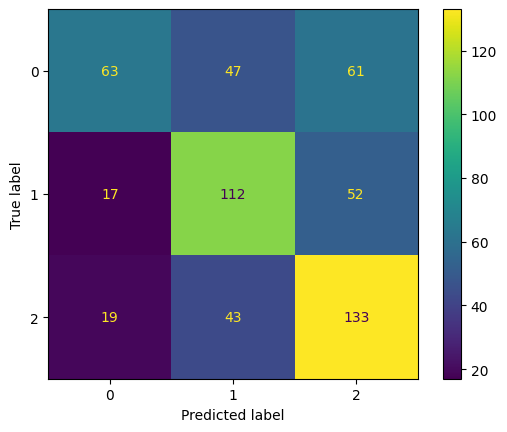

,Record_text,InRelationship,General_comment_binary,General_comment,Specific_comment_binary,label,Comment,Relevance,pred_label
0,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,1,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,0
1,اگه میدونستم که حداقل سعی میکردم جز دوست دخترم...,1,1,1,1.0,1,سوگیری خاصی نسبت به شریک زندگی ندارد,1,1
2,: سیزده به در با خانواده همسر باید بریم یا خان...,1,1,2,1.0,2,یه سواله که با کدوم بروند,1,2
3,اینم از دردسرهای شوهر داشتن روز اول سال بره حک...,1,1,1,1.0,1,بی توجهی همسر,1,1
4,من احساساتم لحظه ایه متاسفانه [PENSIVE_] بعد...,0,1,1,1.0,1,احساسات لحظه ای,1,1
...,...,...,...,...,...,...,...,...,...
542,ظهر از دانشگاه برگشتم خانه دیدم خانمم گریه می ...,1,1,2,1.0,2,کامنت,1,2
543,ظهر، از مسافرتِ چند روزه برگشتیم. به همسرم گفت...,1,1,2,1.0,2,کامنت,1,2
544,چند وقتی می شود ،همسر محترم جرات نمی کنه بهم ب...,1,1,1,1.0,1,کامنت,1,1
545,از اونجایی که همه چیز دو طرفست، وقتی راضی نیست...,1,1,2,1.0,2,کامنت,1,1


In [37]:
Evaluate_models(df_test_unfreeze,model_,'Specific_comment',mode[0])

----------------------------------------------------------------------------------------------------------------------------------------

## Mode: Freeze except layer 11


In [38]:
num_labels=3
model_unfreeze_11 = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'positive', 1: 'negative',2:'neutral'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
model_unfreeze_11=freeze(model_unfreeze_11,mode[1])

layer_._0: False
layer_._1: False
layer_._2: False
layer_._3: False
layer_._4: False
layer_._5: False
layer_._6: False
layer_._7: False
layer_._8: False
layer_._9: False
layer_._10: False
layer_._11: True


In [41]:
#Compile
model_unfreeze_11=compile(model_unfreeze_11)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------

In [42]:
training(model_unfreeze_11,150)

Epoch 1/150
20/20 [==============================] - 29s 614ms/step - loss: 1.0900 - sparse_categorical_accuracy: 0.3914 - val_loss: 1.0806 - val_sparse_categorical_accuracy: 0.4113
Epoch 2/150
20/20 [==============================] - 10s 520ms/step - loss: 1.0831 - sparse_categorical_accuracy: 0.3897 - val_loss: 1.0766 - val_sparse_categorical_accuracy: 0.4095
Epoch 3/150
20/20 [==============================] - 9s 465ms/step - loss: 1.0783 - sparse_categorical_accuracy: 0.4093 - val_loss: 1.0731 - val_sparse_categorical_accuracy: 0.4278
Epoch 4/150
20/20 [==============================] - 10s 523ms/step - loss: 1.0740 - sparse_categorical_accuracy: 0.4223 - val_loss: 1.0705 - val_sparse_categorical_accuracy: 0.4406
Epoch 5/150
20/20 [==============================] - 10s 521ms/step - loss: 1.0722 - sparse_categorical_accuracy: 0.4146 - val_loss: 1.0680 - val_sparse_categorical_accuracy: 0.4388
Epoch 6/150
20/20 [==============================] - 10s 520ms/step - loss: 1.0652 - sparse

---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

:::::::::::::::Performance of ParsBERT'unfreeze_11' on 'Specific_comment' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.51      0.48      0.49       171
           1       0.43      0.48      0.45       181
           2       0.51      0.48      0.50       195

    accuracy                           0.48       547
   macro avg       0.48      0.48      0.48       547
weighted avg       0.48      0.48      0.48       547

Accuracy: 0.480804
    
Precision:0.483626
    
Recall: 0.480749
    
F1 score: 0.481442






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


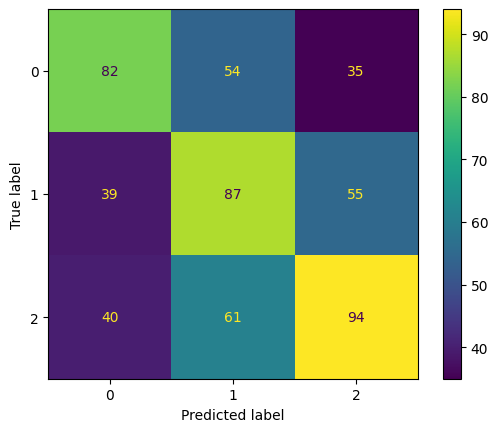

,Record_text,InRelationship,General_comment_binary,General_comment,Specific_comment_binary,label,Comment,Relevance,pred_label
0,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,1,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,1
1,اگه میدونستم که حداقل سعی میکردم جز دوست دخترم...,1,1,1,1.0,1,سوگیری خاصی نسبت به شریک زندگی ندارد,1,0
2,: سیزده به در با خانواده همسر باید بریم یا خان...,1,1,2,1.0,2,یه سواله که با کدوم بروند,1,1
3,اینم از دردسرهای شوهر داشتن روز اول سال بره حک...,1,1,1,1.0,1,بی توجهی همسر,1,1
4,من احساساتم لحظه ایه متاسفانه [PENSIVE_] بعد...,0,1,1,1.0,1,احساسات لحظه ای,1,2
...,...,...,...,...,...,...,...,...,...
542,ظهر از دانشگاه برگشتم خانه دیدم خانمم گریه می ...,1,1,2,1.0,2,کامنت,1,1
543,ظهر، از مسافرتِ چند روزه برگشتیم. به همسرم گفت...,1,1,2,1.0,2,کامنت,1,2
544,چند وقتی می شود ،همسر محترم جرات نمی کنه بهم ب...,1,1,1,1.0,1,کامنت,1,2
545,از اونجایی که همه چیز دو طرفست، وقتی راضی نیست...,1,1,2,1.0,2,کامنت,1,1


In [55]:
Evaluate_models(df_test_unfreeze_11,model_unfreeze_11,'Specific_comment',mode[1])

----------------------------------------------------------------------------------------------------------------------------------------

## Mode: Freeze

In [46]:
num_labels=3
model_freeze = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased",
                                                             num_labels=num_labels,
                                                            id2label={0: 'positive', 1: 'negative',2:'neutral'})

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
model_freeze=freeze(model_freeze,mode[2])

layer_._0: False
layer_._1: False
layer_._2: False
layer_._3: False
layer_._4: False
layer_._5: False
layer_._6: False
layer_._7: False
layer_._8: False
layer_._9: False
layer_._10: False
layer_._11: False


In [49]:
#Compile
model_freeze=compile(model_freeze)

---------------------------------------------------------------------------------------------Training-------------------------------------------------------------------------------------------------------------

In [50]:
training(model_freeze,150)

Epoch 1/150
20/20 [==============================] - 27s 691ms/step - loss: 1.1045 - sparse_categorical_accuracy: 0.3371 - val_loss: 1.0947 - val_sparse_categorical_accuracy: 0.3748
Epoch 2/150
20/20 [==============================] - 11s 559ms/step - loss: 1.0924 - sparse_categorical_accuracy: 0.3665 - val_loss: 1.0848 - val_sparse_categorical_accuracy: 0.4205
Epoch 3/150
20/20 [==============================] - 11s 544ms/step - loss: 1.0834 - sparse_categorical_accuracy: 0.3962 - val_loss: 1.0786 - val_sparse_categorical_accuracy: 0.4260
Epoch 4/150
20/20 [==============================] - 11s 548ms/step - loss: 1.0762 - sparse_categorical_accuracy: 0.4097 - val_loss: 1.0746 - val_sparse_categorical_accuracy: 0.4351
Epoch 5/150
20/20 [==============================] - 11s 550ms/step - loss: 1.0709 - sparse_categorical_accuracy: 0.4191 - val_loss: 1.0718 - val_sparse_categorical_accuracy: 0.4351
Epoch 6/150
20/20 [==============================] - 11s 543ms/step - loss: 1.0724 - spars

---------------------------------------------------------------------------------------------Evaluate_model-------------------------------------------------------------------------------------------------------------

:::::::::::::::Performance of ParsBERT'freeze' on 'Specific_comment' Label:::::::::::::::::::
              precision    recall  f1-score   support

           0       0.52      0.49      0.50       171
           1       0.45      0.46      0.45       181
           2       0.50      0.51      0.51       195

    accuracy                           0.49       547
   macro avg       0.49      0.49      0.49       547
weighted avg       0.49      0.49      0.49       547

Accuracy: 0.488117
    
Precision:0.489056
    
Recall: 0.487537
    
F1 score: 0.488129






-----------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------


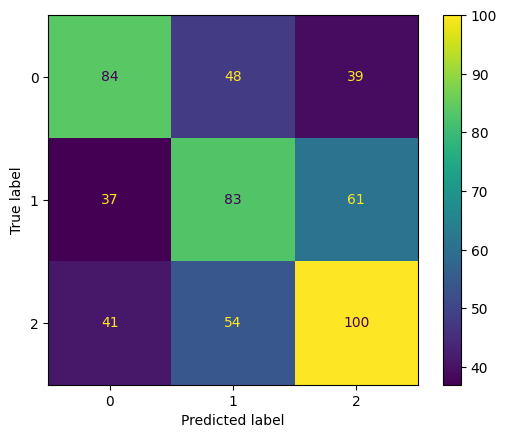

,Record_text,InRelationship,General_comment_binary,General_comment,Specific_comment_binary,label,Comment,Relevance,pred_label
0,: دوست پسر من باید مثل خودم کاسب باشه یعنی چی ...,1,1,1,1.0,1,دوست پسرش بهش پیام داده بریم بیرون اما این خوش...,1,1
1,اگه میدونستم که حداقل سعی میکردم جز دوست دخترم...,1,1,1,1.0,1,سوگیری خاصی نسبت به شریک زندگی ندارد,1,0
2,: سیزده به در با خانواده همسر باید بریم یا خان...,1,1,2,1.0,2,یه سواله که با کدوم بروند,1,1
3,اینم از دردسرهای شوهر داشتن روز اول سال بره حک...,1,1,1,1.0,1,بی توجهی همسر,1,1
4,من احساساتم لحظه ایه متاسفانه [PENSIVE_] بعد...,0,1,1,1.0,1,احساسات لحظه ای,1,2
...,...,...,...,...,...,...,...,...,...
542,ظهر از دانشگاه برگشتم خانه دیدم خانمم گریه می ...,1,1,2,1.0,2,کامنت,1,1
543,ظهر، از مسافرتِ چند روزه برگشتیم. به همسرم گفت...,1,1,2,1.0,2,کامنت,1,2
544,چند وقتی می شود ،همسر محترم جرات نمی کنه بهم ب...,1,1,1,1.0,1,کامنت,1,2
545,از اونجایی که همه چیز دو طرفست، وقتی راضی نیست...,1,1,2,1.0,2,کامنت,1,1


In [53]:
Evaluate_models(df_test_freeze,model_freeze,'Specific_comment',mode[2])